In [1]:
from sktime.datasets import load_japanese_vowels
from sklearn.metrics import confusion_matrix, adjusted_rand_score
from scipy.stats import mode
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from scipy.io import arff
from tqdm import tqdm
from Mc2PCA_class import Mc2PCA

from eval import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## Dataset Japanese Vowels

### Basic experiment

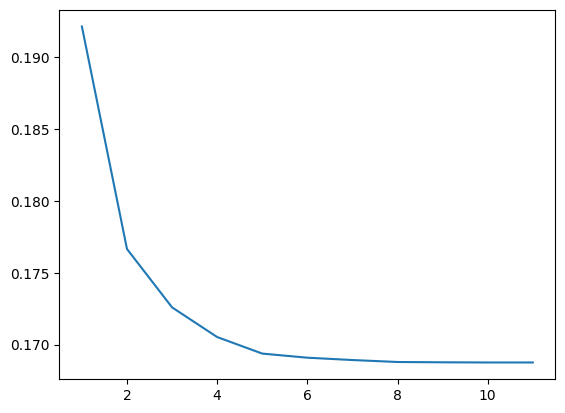

In [18]:
X_train, y_train = load_japanese_vowels(return_X_y=True, split="test")
# the results that are close to the initial paper are on training on the test set
X_train = X_train.sample(frac=1)
y_train = y_train[X_train.index]
K = 9
p = 3
seuil = 1e-7
model = Mc2PCA(K, p, seuil, max_iter=50)
idx, E, _ = model.fit(X_train)
plt.plot(E)
plt.show()

Adjusted Rand Index: 0.21128730957909253
Precision: 0.48378378378378384
Recall: 0.44324324324324327


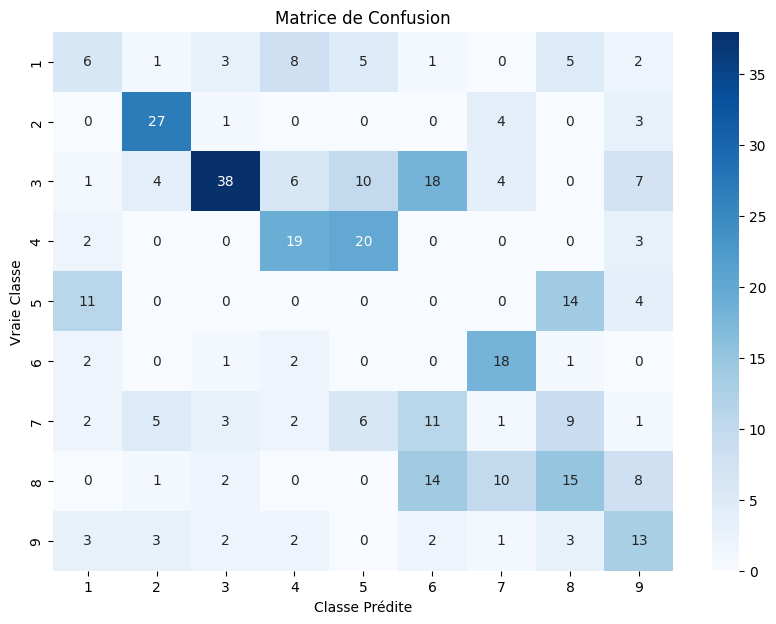

(0.21128730957909253, 0.48378378378378384, 0.44324324324324327)

In [19]:
metrics(y_train, idx, plot=True)

Adjusted Rand Index: 0.2302790789460018
Precision: 0.4740740740740741
Recall: 0.45925925925925926


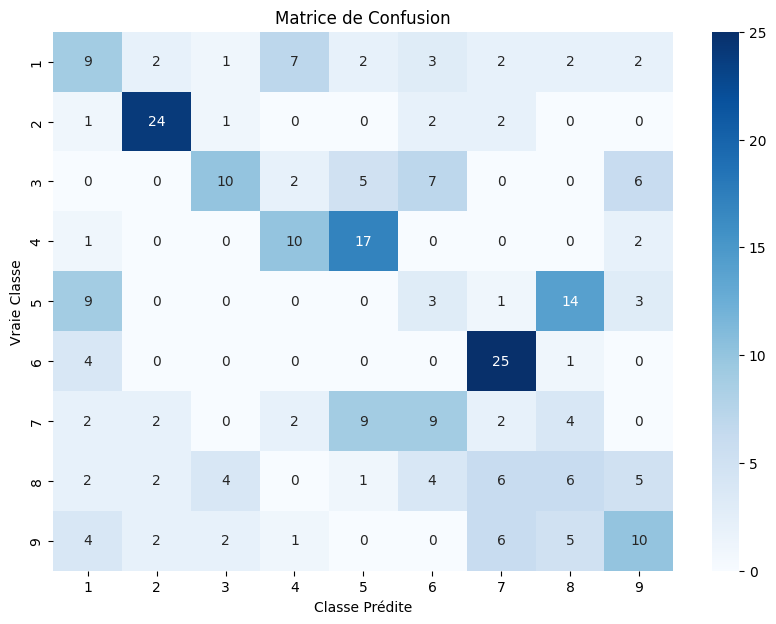

(0.2302790789460018, 0.4740740740740741, 0.45925925925925926)

In [21]:
X_test, y_test = load_japanese_vowels(return_X_y=True, split="train")
idx_test = model.inference(X_test)
metrics(y_test, idx_test, plot=True)

### Compute the results without shuffling which are close to the paper results

In [23]:
df = pd.DataFrame(columns=["p","ARI","Precision","Recall"])
ari_scores=[]
precisions=[]
recalls=[]

X_, y_= load_japanese_vowels(return_X_y=True, split="test")

precision, ari_score, recall = get_p_histo(X_, K=9, y_test=y_, seuil = 1e-7, max_iter = 50, p_max=4)

ari_scores.append(ari_score)
precisions.append(precision)
recalls.append(recall)
precisions = np.array(precisions)
recalls = np.array(recalls)
ari_scores = np.array(ari_scores)

df["p"] = np.arange(1, precisions.shape[1] + 1)
df["ARI"] = np.mean(ari_scores, axis=0).round(4)
df["Precision"] = np.mean(precisions, axis=0).round(4)
df["Recall"] = np.mean(recalls, axis=0).round(4)
df

,p,ARI,Precision,Recall
0,1,0.2301,0.5324,0.5000
1,2,0.2766,0.5838,0.5324
2,3,0.3143,0.6108,0.5568
3,4,0.3611,0.6297,0.6027


### Compute for all p values the results with shuffling 50 times and take the mean and std

In [76]:
ari_scores=[]
precisions=[]
recalls=[]
df = pd.DataFrame(columns=["p","ARI_mean","ARI_std","Precision_mean","Precision_std","Recall_mean","Recall_std"])

X_, y_= load_japanese_vowels(return_X_y=True, split="test")

for i in tqdm(range(50), desc="Iteration", position=0):
    np.random.seed(i)
    # shuffle rows
    X_train = X_.sample(frac=1)
    y_train = y_[X_train.index]

    precision, ari_score, recall = get_p_histo(X_train, K=9, y_test=y_train, seuil = 1e-7, max_iter = 50)
    
    ari_scores.append(ari_score)
    precisions.append(precision)
    recalls.append(recall)

precisions = np.array(precisions)
recalls = np.array(recalls)
ari_scores = np.array(ari_scores)

df["p"] = np.arange(1, precisions.shape[1] + 1)
df["ARI_mean"] = np.mean(ari_scores, axis=0)
df["ARI_std"] = np.std(ari_scores, axis=0)
df["Precision_mean"] = np.mean(precisions, axis=0)
df["Precision_std"] = np.std(precisions, axis=0)
df["Recall_mean"] = np.mean(recalls, axis=0)
df["Recall_std"] = np.std(recalls, axis=0)

df.to_csv("results_japanese_vowel.csv", index=False)
df

Iteration: 100%|██████████| 50/50 [17:11<00:00, 20.64s/it]


,p,ARI_mean,ARI_std,Precision_mean,Precision_std,Recall_mean,Recall_std
0,1,0.209527,0.020299,0.486486,0.026968,0.466595,0.024039
1,2,0.233803,0.033416,0.510649,0.034039,0.490595,0.036193
2,3,0.242808,0.035285,0.517784,0.032996,0.483459,0.035004
3,4,0.242872,0.046153,0.515676,0.052730,0.495027,0.049312
4,5,0.210621,0.038342,0.483838,0.043434,0.458162,0.044810
5,6,0.178793,0.031548,0.452865,0.037129,0.442000,0.036298
6,7,0.134442,0.027465,0.405784,0.036071,0.388378,0.033866
7,8,0.109132,0.019937,0.376378,0.028211,0.369676,0.027859
8,9,0.085815,0.018651,0.345027,0.024904,0.339568,0.028709
9,10,0.063172,0.018223,0.325730,0.026592,0.307135,0.026754


### Compute the results for different distance metrics for the reconstruction error.

In [27]:
ari_scores=[]
precisions=[]
recalls=[]
df = pd.DataFrame(columns=["ARI_mean","ARI_std","Precision_mean","Precision_std","Recall_mean","Recall_std"])

X_, y_= load_japanese_vowels(return_X_y=True, split="test")

for i in tqdm(range(10), desc="Iteration", position=0):
    np.random.seed(i)
    # shuffle rows
    X_train = X_.sample(frac=1)
    y_train = y_[X_train.index]

    precision, ari_score, recall = get_results_distance(X_train, K=9, y_test=y_train, seuil = 1e-7, max_iter = 50)
    
    ari_scores.append(ari_score)
    precisions.append(precision)
    recalls.append(recall)

precisions = np.array(precisions)
recalls = np.array(recalls)
ari_scores = np.array(ari_scores)

df["distance_metric"] = ["euclidean", "dtw", "l1", "cosine"]
df["ARI_mean"] = np.mean(ari_scores, axis=0)
df["ARI_std"] = np.std(ari_scores, axis=0)
df["Precision_mean"] = np.mean(precisions, axis=0)
df["Precision_std"] = np.std(precisions, axis=0)
df["Recall_mean"] = np.mean(recalls, axis=0)
df["Recall_std"] = np.std(recalls, axis=0)

df.to_csv("results_japanese_vowel_distance.csv", index=False)

df

,distance_metric,ARI_mean,ARI_std,Precision_mean,Precision_std,Recall_mean,Recall_std
0,euclidean,0.246554,0.046562,0.524054,0.028818,0.493243,0.037063
1,dtw,0.225952,0.030241,0.515135,0.035285,0.467838,0.039656
2,l1,0.247413,0.038138,0.520541,0.048169,0.495676,0.035839
3,cosine,0.265831,0.031560,0.531351,0.027435,0.501081,0.035757


### Evaluate the p optimal value

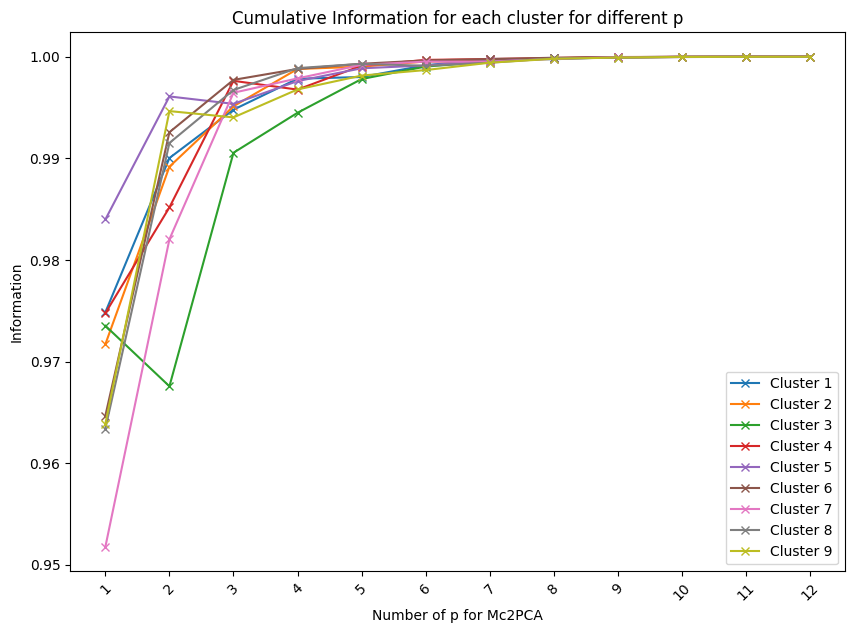

In [2]:
X, y= load_japanese_vowels(return_X_y=True, split="test")
X = X.sample(frac=1)
y = y[X.index]
plot_info(X, 9, seuil = 1e-7, max_iter = 50)

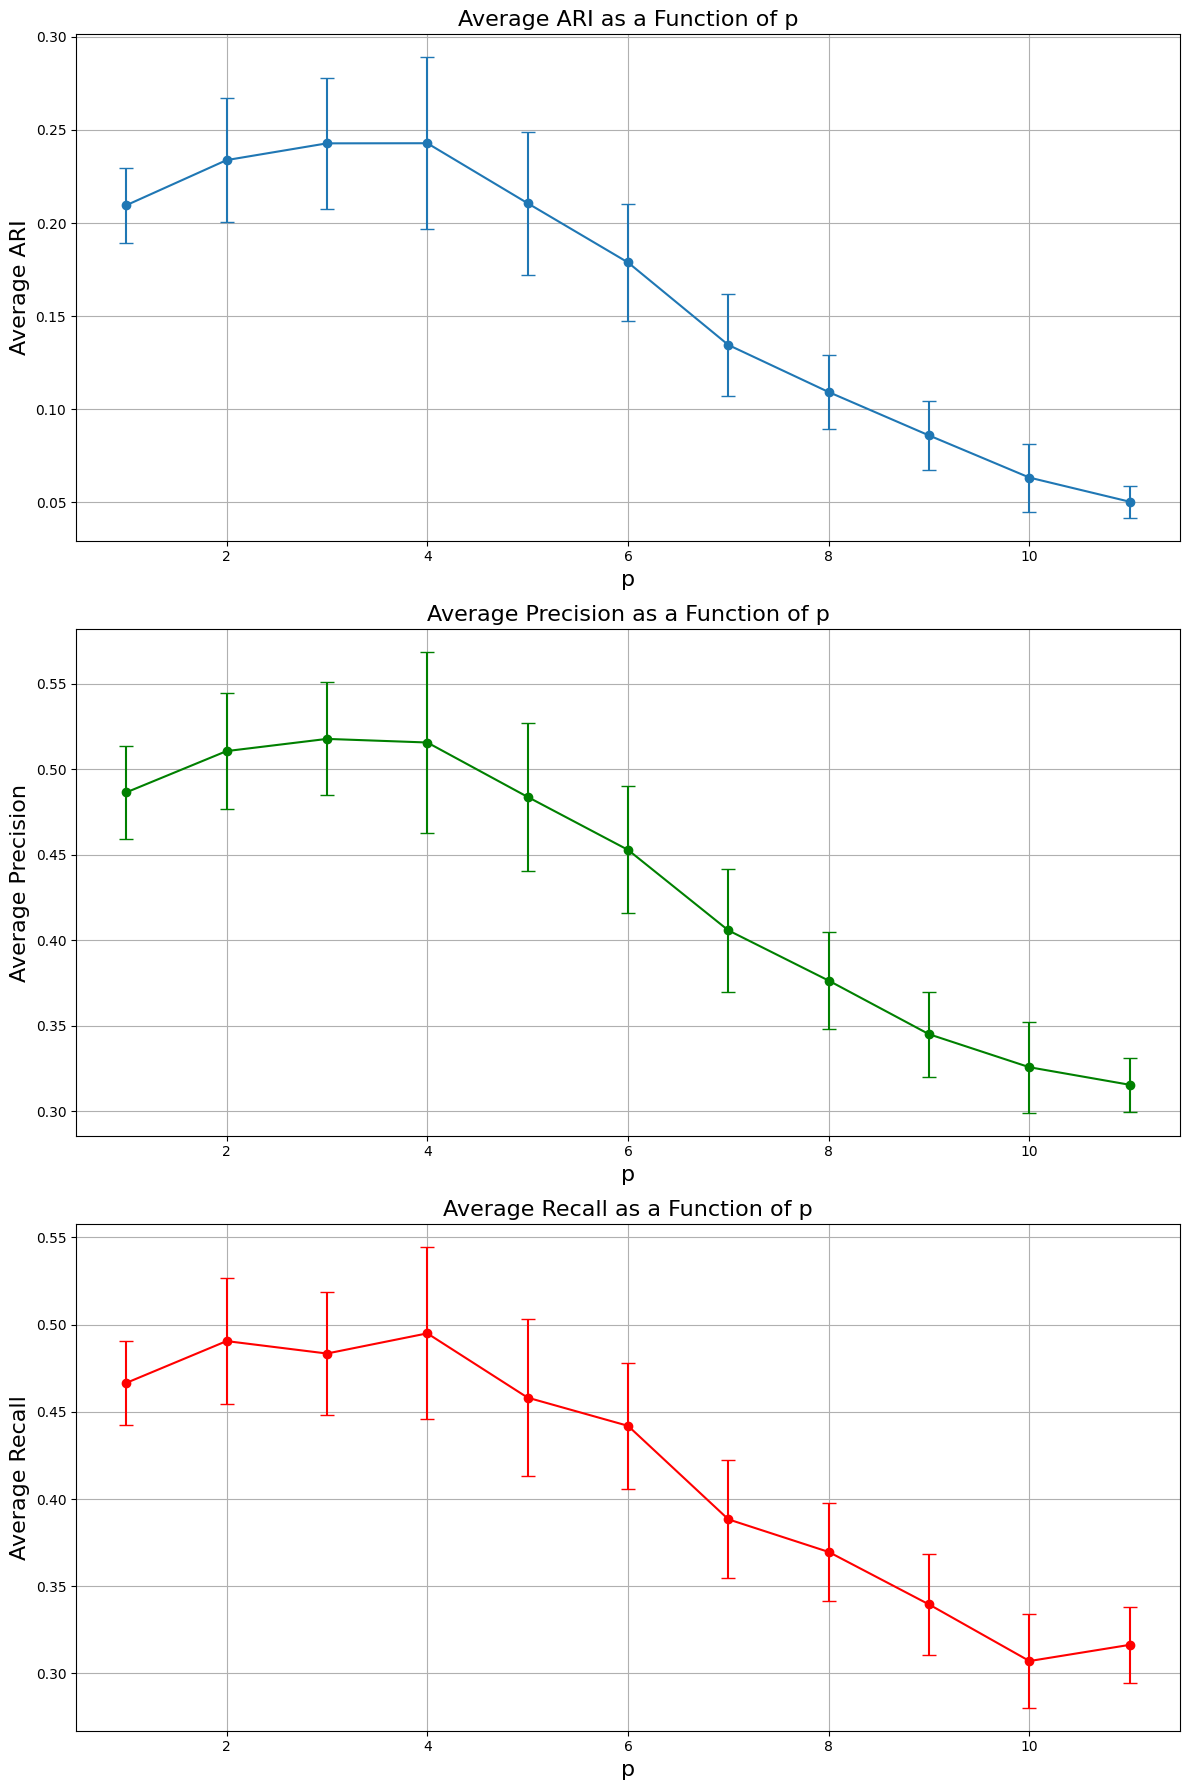

In [3]:
df = pd.read_csv("results_japanese_vowel.csv")

# Load the data
p = df['p']
ari_mean = df['ARI_mean']
ari_std = df['ARI_std']
precision_mean = df['Precision_mean']
precision_std = df['Precision_std']
recall_mean = df['Recall_mean']
recall_std = df['Recall_std']

fig, ax = plt.subplots(3, 1, figsize=(12, 18))

# Plot for ARI
ax[0].errorbar(p, ari_mean, yerr=ari_std, fmt='-o', capsize=5, label='ARI')
ax[0].set_title('Average ARI as a Function of p', fontsize=16)
ax[0].set_xlabel('p', fontsize=16)
ax[0].set_ylabel('Average ARI', fontsize=16)
ax[0].grid(True)

# Plot for Precision
ax[1].errorbar(p, precision_mean, yerr=precision_std, fmt='-o', capsize=5, color='green', label='Precision')
ax[1].set_title('Average Precision as a Function of p', fontsize=16)
ax[1].set_xlabel('p', fontsize=16)
ax[1].set_ylabel('Average Precision', fontsize=16)
ax[1].grid(True)

# Plot for Recall²
ax[2].errorbar(p, recall_mean, yerr=recall_std, fmt='-o', capsize=5, color='red', label='Recall')
ax[2].set_title('Average Recall as a Function of p', fontsize=16)
ax[2].set_xlabel('p', fontsize=16)
ax[2].set_ylabel('Average Recall', fontsize=16)
ax[2].grid(True)

plt.tight_layout()
plt.show()

## Dataset CMU\_MOCAP\_S16

### Load the data

In [2]:
from load_data import *
X, y = load_MOCAP()

# X = X.iloc[:29, :]
# y = y[:29]

X.shape

(58, 62)

### Compute for all p values the results with shuffling 50 times and take the mean and std

In [21]:
ari_scores=[]
precisions=[]
recalls=[]
df = pd.DataFrame(columns=["p","ARI_mean","ARI_std","Precision_mean","Precision_std","Recall_mean","Recall_std"])

for i in tqdm(range(50), desc="Iteration", position=0):
    np.random.seed(i)
    # # shuffle rows
    X_eval = X.sample(frac=1)
    y_eval = y[X.index]
    precision, ari_score, recall = get_p_histo(X_eval, K=2, y_test=y_eval, seuil = 1e-7, max_iter = 50)
    
    ari_scores.append(ari_score)
    precisions.append(precision)
    recalls.append(recall)

precisions = np.array(precisions)
recalls = np.array(recalls)
ari_scores = np.array(ari_scores)

df["p"] = np.arange(1, precisions.shape[1] + 1)
df["ARI_mean"] = np.mean(ari_scores, axis=0)
df["ARI_std"] = np.std(ari_scores, axis=0)
df["Precision_mean"] = np.mean(precisions, axis=0)
df["Precision_std"] = np.std(precisions, axis=0)
df["Recall_mean"] = np.mean(recalls, axis=0)
df["Recall_std"] = np.std(recalls, axis=0)

df.to_csv("results_mocap_full.csv", index=False)
df

Iteration: 100%|██████████| 50/50 [12:41<00:00, 15.22s/it]


,p,ARI_mean,ARI_std,Precision_mean,Precision_std,Recall_mean,Recall_std
0,1,0.052196,0.115697,0.844828,1.110223e-16,0.696897,0.027389
1,2,-0.015860,0.205769,0.846207,6.757213e-03,0.841379,0.026932
2,3,0.171547,0.341222,0.863793,3.554401e-02,0.829310,0.077279
3,4,0.264160,0.286114,0.859310,3.052455e-02,0.799655,0.081081
4,5,0.078710,0.157143,0.846207,9.655172e-03,0.680345,0.074455
...,...,...,...,...,...,...,...
56,57,-0.016379,0.077830,0.844828,1.110223e-16,0.913793,0.079310
57,58,-0.009779,0.076437,0.844828,1.395529e-16,0.899310,0.118118
58,59,-0.012905,0.077590,0.845517,4.827586e-03,0.884138,0.125094
59,60,-0.032664,0.077299,0.844828,1.439014e-16,0.856897,0.114275


### To have a class-balanced dataset, we recovered less data and all the data from the weakest class.

In [2]:
from load_data import *
X, y = load_MOCAP()
X = X.iloc[:29, :]
y = y[:29]
# load csv mocap full
df = pd.read_csv("results_mocap_29.csv") # We already trained for the Reduced MOCAP dataset
df

,p,ARI_mean,ARI_std,Precision_mean,Precision_std,Recall_mean,Recall_std
0,1,0.195029,0.157482,0.751724,4.626348e-02,0.732414,0.074137
1,2,0.102541,0.246627,0.739310,7.172414e-02,0.809655,0.039761
2,3,0.429113,0.281773,0.836552,8.608543e-02,0.855172,0.058924
3,4,0.412256,0.238263,0.822759,8.418597e-02,0.822069,0.086237
4,5,0.516296,0.262600,0.857241,8.778148e-02,0.856552,0.089219
...,...,...,...,...,...,...,...
56,57,-0.044629,0.018804,0.689655,3.330669e-16,0.929655,0.072973
57,58,0.011917,0.085011,0.697241,1.985680e-02,0.830345,0.133523
58,59,0.006664,0.093911,0.697931,2.631556e-02,0.844138,0.115862
59,60,0.025699,0.099845,0.702069,2.737853e-02,0.828966,0.124513


### Evaluate the p optimal value

  0%|          | 0/50 [00:00<?, ?it/s]

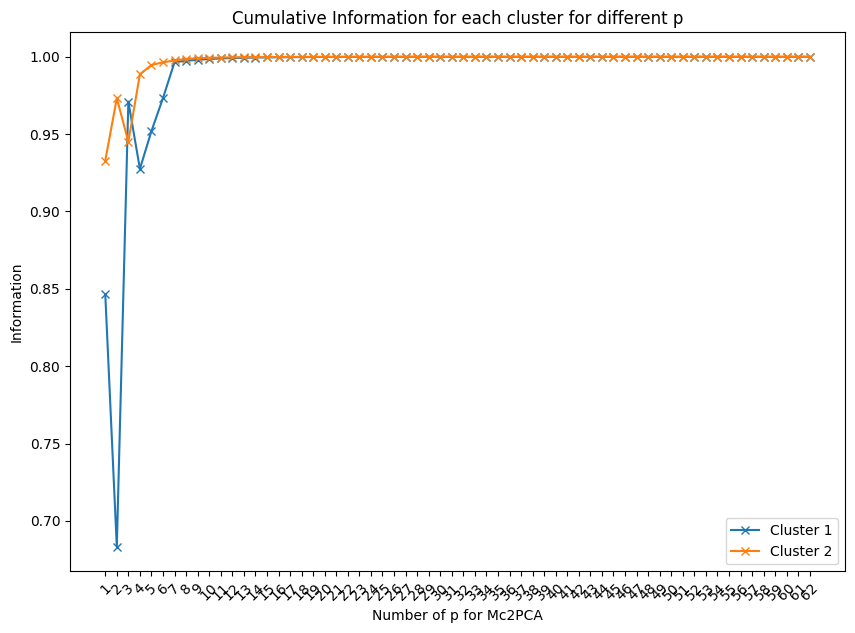

In [3]:
plot_info(X, 2, seuil = 1e-7, max_iter = 50)

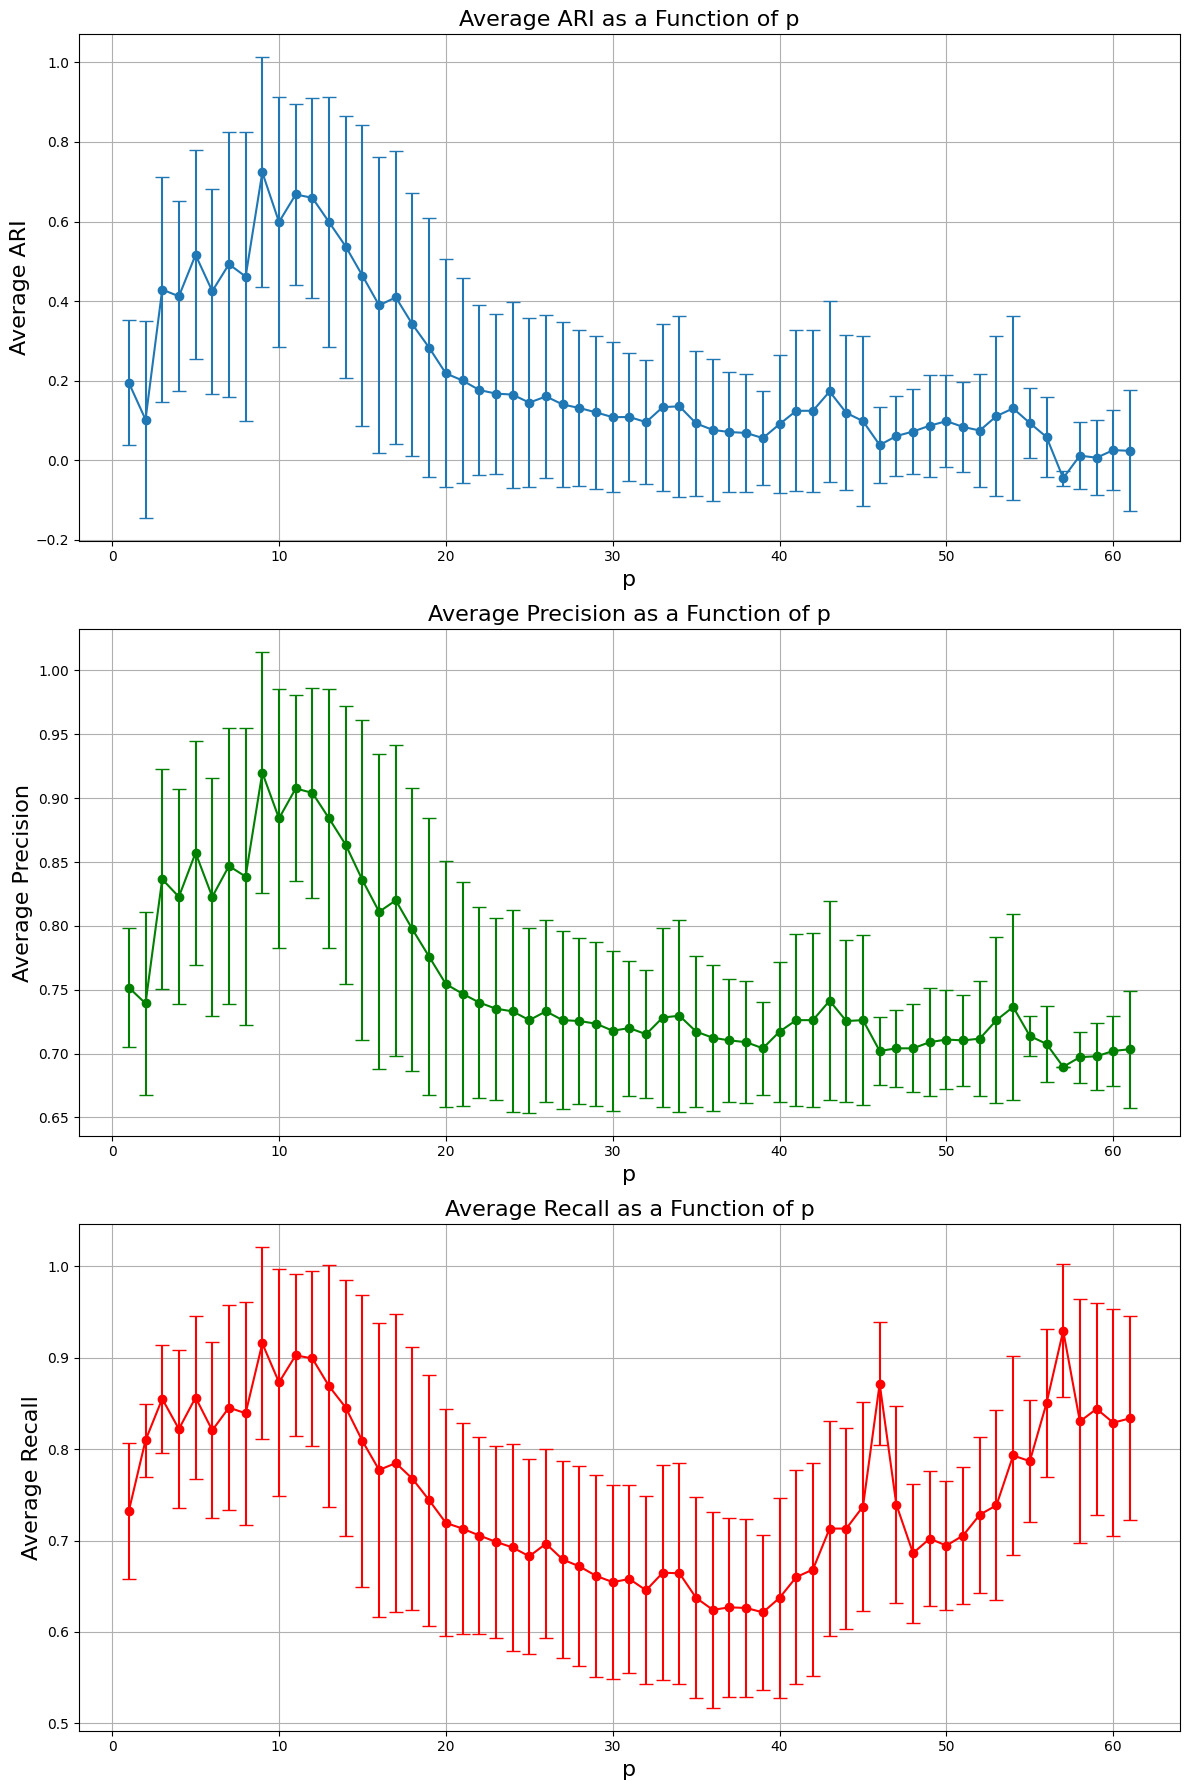

In [4]:
df = pd.read_csv("results_mocap_29.csv")

# Load the data
p = df['p']
ari_mean = df['ARI_mean']
ari_std = df['ARI_std']
precision_mean = df['Precision_mean']
precision_std = df['Precision_std']
recall_mean = df['Recall_mean']
recall_std = df['Recall_std']

fig, ax = plt.subplots(3, 1, figsize=(12, 18))

# Plot for ARI
ax[0].errorbar(p, ari_mean, yerr=ari_std, fmt='-o', capsize=5, label='ARI')
ax[0].set_title('Average ARI as a Function of p', fontsize=16)
ax[0].set_xlabel('p', fontsize=16)
ax[0].set_ylabel('Average ARI', fontsize=16)
ax[0].grid(True)

# Plot for Precision
ax[1].errorbar(p, precision_mean, yerr=precision_std, fmt='-o', capsize=5, color='green', label='Precision')
ax[1].set_title('Average Precision as a Function of p', fontsize=16)
ax[1].set_xlabel('p', fontsize=16)
ax[1].set_ylabel('Average Precision', fontsize=16)
ax[1].grid(True)

# Plot for Recall²
ax[2].errorbar(p, recall_mean, yerr=recall_std, fmt='-o', capsize=5, color='red', label='Recall')
ax[2].set_title('Average Recall as a Function of p', fontsize=16)
ax[2].set_xlabel('p', fontsize=16)
ax[2].set_ylabel('Average Recall', fontsize=16)
ax[2].grid(True)

plt.tight_layout()
plt.show()

## Dataset Epilepsy

### Load the data

In [3]:
X, y = load_Epilepsy()
X.shape

(137, 3)

In [105]:
ari_scores=[]
precisions=[]
recalls=[]
df = pd.DataFrame(columns=["p","ARI_mean","ARI_std","Precision_mean","Precision_std","Recall_mean","Recall_std"])


for i in tqdm(range(50), desc="Iteration", position=0):
    # # shuffle rows
    np.random.seed(i)
    X_eval = X.sample(frac=1)
    y_eval = y[X.index]
    precision, ari_score, recall = get_p_histo(X_eval, K=4, y_test=y_eval, seuil = 1e-7, max_iter = 50)
    
    ari_scores.append(ari_score)
    precisions.append(precision)
    recalls.append(recall)

precisions = np.array(precisions)
recalls = np.array(recalls)
ari_scores = np.array(ari_scores)

df["p"] = np.arange(1, precisions.shape[1] + 1)
df["ARI_mean"] = np.mean(ari_scores, axis=0)
df["ARI_std"] = np.std(ari_scores, axis=0)
df["Precision_mean"] = np.mean(precisions, axis=0)
df["Precision_std"] = np.std(precisions, axis=0)
df["Recall_mean"] = np.mean(recalls, axis=0)
df["Recall_std"] = np.std(recalls, axis=0)

df.to_csv("results_epilepsy.csv", index=False)
df

Iteration: 100%|██████████| 50/50 [00:23<00:00,  2.09it/s]


,p,ARI_mean,ARI_std,Precision_mean,Precision_std,Recall_mean,Recall_std
0,1,0.225609,0.014205,0.510657,0.027582,0.642190,0.014488
1,2,0.110266,0.026155,0.462336,0.035896,0.502044,0.048666
2,3,0.059250,0.069017,0.357372,0.080728,0.847445,0.135375
